# Library import

In [1]:
from Annotation_Untils import singular_comment_with_annotation, singular_comment_without_annotation, annotate_comment, auto_label
from DataCleaning_Untils import clean_comment

import pandas as pd
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, roc_curve, auc, precision_recall_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

c:\Users\nkhoa2\Desktop\Github\Test\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use cpu
Device set to use cpu


# Data Load

In [2]:
path = os.path.join(os.getcwd(), 'Data', 'Train', 'train.csv') # Adjust the path as needed
df = pd.read_csv(path)
df = df.dropna(subset=['comment_text'])
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [3]:
df = df[['id', 'comment_text']]

In [4]:
df.head()

,id,comment_text
0,59848,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!"
1,59849,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"
2,59852,This is such an urgent design problem; kudos to you for taking it on. Very impressive!
3,59855,Is this something I'll be able to install on my site? When will you be releasing it?
4,59856,haha you guys are a bunch of losers.


## Clean the Data (Optional)

In [5]:
flag_loader = True # Set to True to load in cleaned csv, else it will clean the data (AGAIN!)

if flag_loader:
    df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'Train', 'cleaned_train.csv'))
else:
    # Clean the comments
    df['comment_text'] = df['comment_text'].apply(clean_comment)
    # Save the cleaned data
    df.to_csv(os.path.join(os.getcwd(), 'Data', 'Train', 'cleaned_train.csv'), index=False)

In [6]:
df.head()

,comment_text
0,this is so cool its like would you want your mother to read this really great idea well done
1,thank you this would make my life a lot less anxietyinducing keep it up and dont let anyone get in your way
2,this is such an urgent design problem kudos to you for taking it on very impressive
3,is this something ill be able to install on my site when will you be releasing it
4,hata you guns are a bunch of losers


## Sample the Data

In [7]:
flag_test = True # Set to True to go with sample test data, else it will use the full dataset
if flag_test:
    df = df.sample(3000, random_state=42).reset_index(drop=True)
else: 
    df = df.sample(1500000, random_state=42).reset_index(drop=True)

df = df[df["comment_text"].notnull()]
comments = df["comment_text"].astype(str).tolist()

# Model Training

## Data Preparation

### Scalar feature computation

In [8]:
processed_training_data = annotate_comment(comments)
processed_training_data = pd.DataFrame(processed_training_data)
processed_training_data['label'] = processed_training_data.apply(auto_label, axis=1)
processed_training_data = pd.get_dummies(processed_training_data, columns=['sentiment', 'emotion'])

Annotating comments: 100%|██████████| 2995/2995 [12:05<00:00,  4.13it/s]


In [9]:
processed_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   comment             2995 non-null   object 
 1   hate_score          2995 non-null   float64
 2   toxicity            2995 non-null   float64
 3   obscene             2995 non-null   float64
 4   identity_attack     2995 non-null   float64
 5   insult              2995 non-null   float64
 6   threat              2995 non-null   float64
 7   sexual_explicit     2995 non-null   float64
 8   label               2995 non-null   object 
 9   sentiment_negative  2995 non-null   bool   
 10  sentiment_neutral   2995 non-null   bool   
 11  sentiment_positive  2995 non-null   bool   
 12  emotion_anger       2995 non-null   bool   
 13  emotion_fear        2995 non-null   bool   
 14  emotion_joy         2995 non-null   bool   
 15  emotion_love        2995 non-null   bool   
 16  emotio

In [10]:
scalar_feature_cols = [
    'hate_score', 'toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit',
    'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
    'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise'
]

for col in scalar_feature_cols:
    processed_training_data[col] = processed_training_data[col].astype(float)

label_mapping = {
    'keep': 0,  
    'delete': 1 
}
processed_training_data['label'] = processed_training_data['label'].map(label_mapping)

## Model Preparation

### Fine tune BERT model approach

#### BERT model preparation

In [ ]:
# Experiment

class BertWithScalarFeatures(nn.Module):
    def __init__(self, scalar_feature_dim, num_classes):
        super(BertWithScalarFeatures, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size + scalar_feature_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, input_ids, attention_mask, scalar_features):
        # BERT output
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]
        
        combined_features = torch.cat((cls_embedding, scalar_features), dim=1)
        x = F.relu(self.fc1(combined_features))
        x = self.fc2(x)

        return x

    def predict_proba(self, input_ids, attention_mask, scalar_features):
        logits = self.forward(input_ids, attention_mask, scalar_features)
        
        probabilities = F.softmax(logits, dim=1)
        return probabilities
    
class CommentDataset(Dataset):
    def __init__(self, comments, scalar_features, labels, tokenizer, max_len=128):
        self.comments = comments
        self.scalar_features = scalar_features
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments[idx]
        scalar_feat = torch.tensor(self.scalar_features[idx], dtype=torch.float)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        encoded = self.tokenizer(
            comment,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'scalar_features': scalar_feat,
            'label': label
        }

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

comments = processed_training_data['comment'].tolist()

scalar_features = processed_training_data[[
    'hate_score', 'toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit',
    'sentiment_negative', 'sentiment_neutral', 'sentiment_positive',
    'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise'
]].values

labels = processed_training_data['label'].values

X_train_comments, X_val_comments, X_train_scalar, X_val_scalar, y_train, y_val = train_test_split(
    comments,
    scalar_features,
    labels,
    test_size=0.2,    # 20% validation
    random_state=42,
    stratify=labels
)

train_dataset = CommentDataset(
    comments=X_train_comments,
    scalar_features=X_train_scalar,
    labels=y_train,
    tokenizer=tokenizer
)

val_dataset = CommentDataset(
    comments=X_val_comments,
    scalar_features=X_val_scalar,
    labels=y_val,
    tokenizer=tokenizer
)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#### Fine tuning BERT model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertWithScalarFeatures(scalar_feature_dim=16, num_classes=2)
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 5

train_losses = []
val_losses = []
val_accuracies = []

model.train()
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    # Train phase
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scalar_features = batch['scalar_features'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, scalar_features=scalar_features)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch + 1} | Loss: {avg_loss:.4f}")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    correct_predictions = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            scalar_features = batch['scalar_features'].to(device)
            labels = batch['label'].to(device)

            # Forward pass (no gradient computation)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, scalar_features=scalar_features)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Get predicted labels and count correct predictions
            _, predicted = torch.max(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = correct_predictions / len(val_dataloader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

Epoch 1 | Loss: 0.3872
Epoch 1 | Val Loss: 0.3538 | Val Accuracy: 0.8715
Epoch 2 | Loss: 0.3098
Epoch 2 | Val Loss: 0.3589 | Val Accuracy: 0.8731
Epoch 3 | Loss: 0.1651
Epoch 3 | Val Loss: 0.5096 | Val Accuracy: 0.8331
Epoch 4 | Loss: 0.0634
Epoch 4 | Val Loss: 0.5791 | Val Accuracy: 0.8748
Epoch 5 | Loss: 0.0300
Epoch 5 | Val Loss: 0.6151 | Val Accuracy: 0.8481


#### Fine tune BERT Evaluation

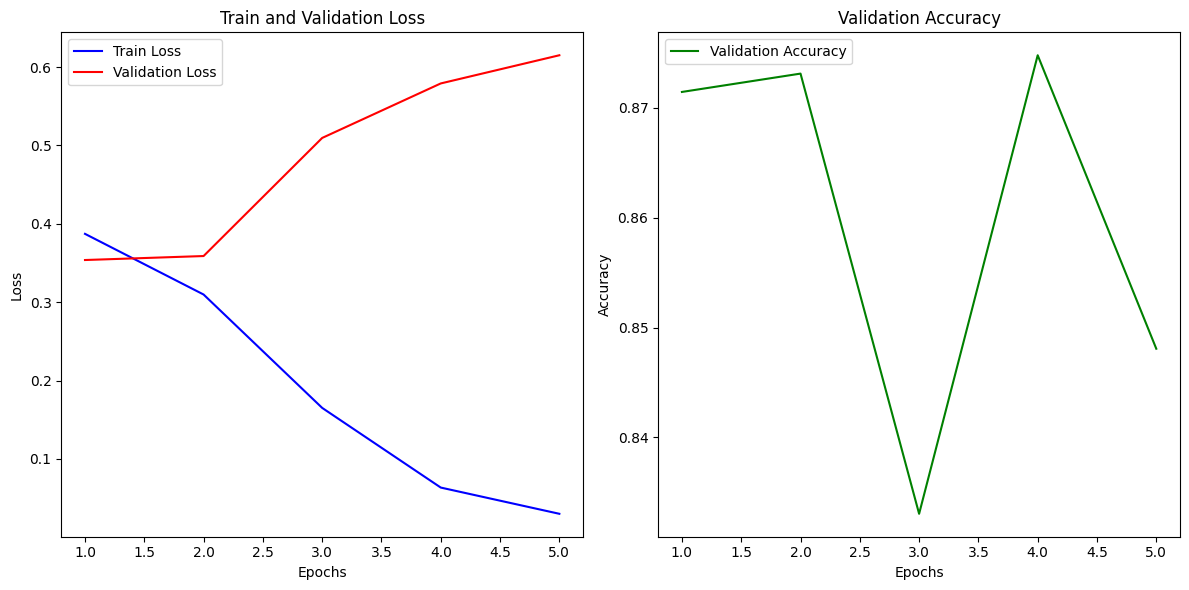

In [14]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Validation Loss: 0.6151
Validation Accuracy: 0.8481
Precision: 0.3600
Recall: 0.2338
F1-Score: 0.2835
Confusion Matrix:
[[490  32]
 [ 59  18]]


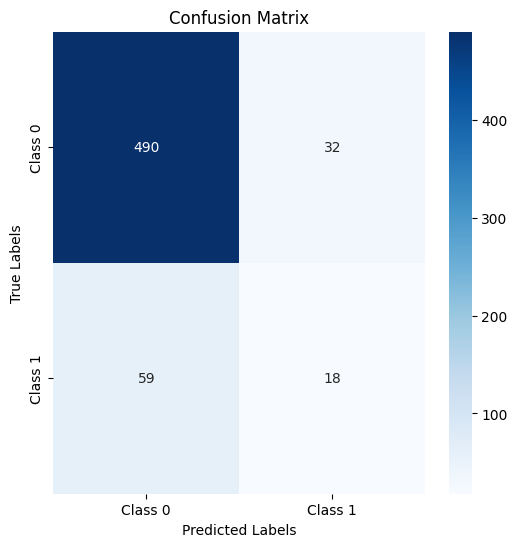

In [15]:
model.eval()  # Ensure the model is in eval mode
total_val_loss = 0
correct_predictions = 0
all_preds = []
all_labels = []
y_probs = []
y_true = []


with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scalar_features = batch['scalar_features'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, scalar_features=scalar_features)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item()

        # Get predicted labels
        _, predicted = torch.max(outputs, dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct_predictions += (predicted == labels).sum().item()

        probs = model.predict_proba(input_ids, attention_mask, scalar_features)
        y_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
        y_true.extend(labels.cpu().numpy())

# Calculate average validation loss and accuracy
avg_val_loss = total_val_loss / len(val_dataloader)
val_accuracy = correct_predictions / len(val_dataloader.dataset)

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

# Print evaluation statistics
print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix:\n{conf_matrix}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

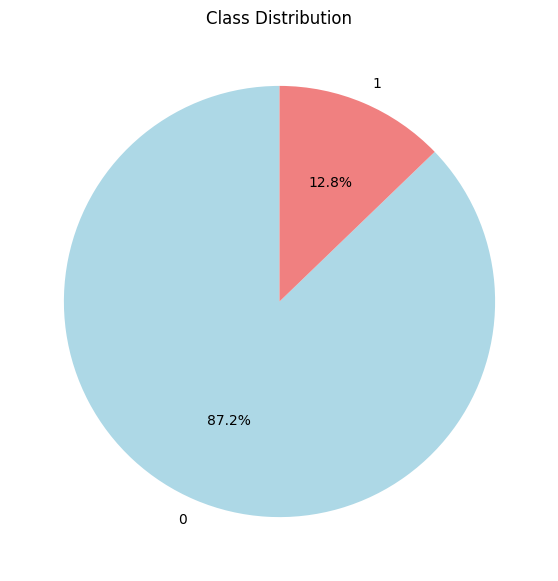

In [16]:
class_counts = processed_training_data['label'].value_counts()

plt.figure(figsize=(7, 7))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Class Distribution')
plt.show()

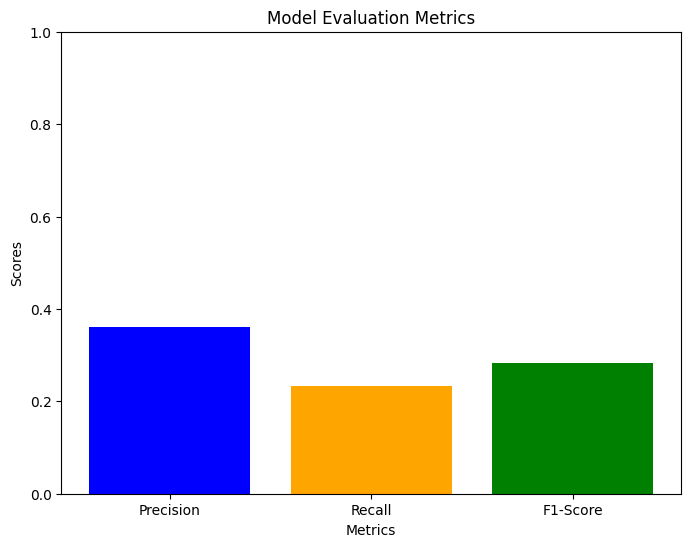

In [17]:
metrics = ['Precision', 'Recall', 'F1-Score']
scores = [precision, recall, f1]

# Bar chart for evaluation metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics, scores, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)
plt.title('Model Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.show()

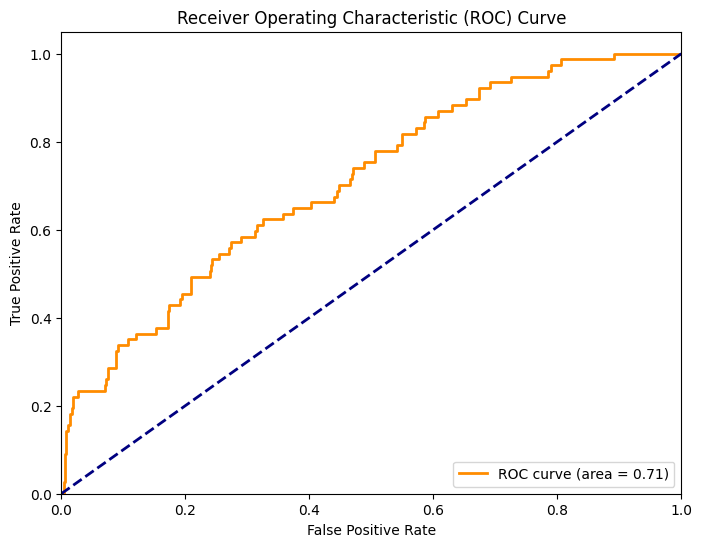

In [18]:
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

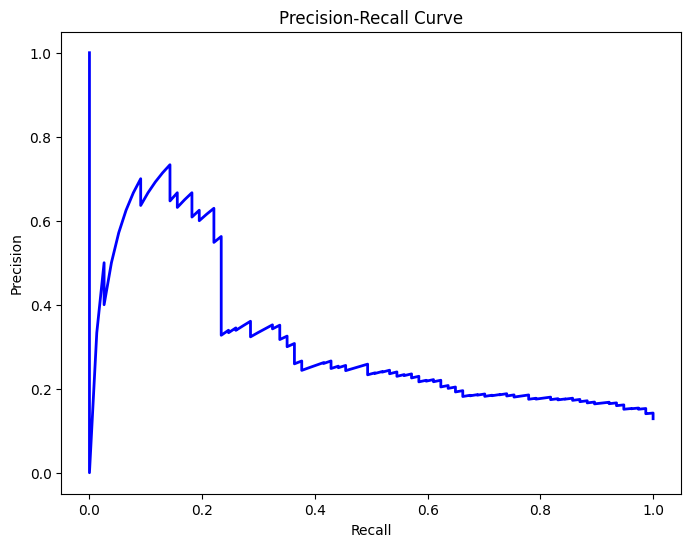

In [19]:
precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

#### Testing the model on a single comment

In [20]:
test_str = singular_comment_without_annotation("fuck you!")
test_str

{'comment': 'fuck you!',
 'sentiment': 'negative',
 'hate_score': 0.09883905947208405,
 'emotion': 'anger',
 'toxicity': 0.0,
 'obscene': 0.9928935170173645,
 'identity_attack': 0.0,
 'insult': 0.9431484937667847,
 'threat': 0.003771663410589099,
 'sexual_explicit': 0.0}

In [21]:
def predict_single_comment_with_features(test_dict, model, tokenizer, device):
    model.eval()

    comment = test_dict['comment']

    # 1. Tokenize text
    inputs = tokenizer(comment, return_tensors='pt', truncation=True, max_length=128, padding='max_length')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # 2. Build scalar feature vector
    scalar_features = np.array([
        test_dict['hate_score'],
        test_dict['toxicity'],
        test_dict['obscene'],
        test_dict['identity_attack'],
        test_dict['insult'],
        test_dict['threat'],
        test_dict['sexual_explicit'],
        1.0 if test_dict['sentiment'] == 'negative' else 0.0,
        1.0 if test_dict['sentiment'] == 'neutral' else 0.0,
        1.0 if test_dict['sentiment'] == 'positive' else 0.0,
        1.0 if test_dict['emotion'] == 'anger' else 0.0,
        1.0 if test_dict['emotion'] == 'fear' else 0.0,
        1.0 if test_dict['emotion'] == 'joy' else 0.0,
        1.0 if test_dict['emotion'] == 'love' else 0.0,
        1.0 if test_dict['emotion'] == 'sadness' else 0.0,
        1.0 if test_dict['emotion'] == 'surprise' else 0.0
    ], dtype=np.float32)

    scalar_features = torch.tensor(scalar_features).unsqueeze(0).to(device)  # shape (1, 16)

    # 3. Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, scalar_features=scalar_features)
        probs = torch.softmax(outputs, dim=1)
        pred_label = torch.argmax(probs, dim=1).item()

    return pred_label, probs.cpu().numpy()

In [26]:
test_str = singular_comment_without_annotation(clean_comment("suck yor dick! This article is aass!"))
pred_label, probabilities = predict_single_comment_with_features(test_str, model, tokenizer, device)

label_map = {0: "keep", 1: "delete"}
print(f"Predicted label: {label_map[pred_label]}")
print(f"Probabilities: {probabilities}")

Predicted label: delete
Probabilities: [[0.0082774  0.99172264]]


### BERT & SVM model approach

#### Pretrained BERT embedding

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding (pooled representation)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

processed_training_data['bert_embedding'] = processed_training_data['comment'].apply(get_bert_embedding)

scalar_features = processed_training_data[['hate_score', 'toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit', \
                                           'sentiment_negative', 'sentiment_neutral', 'sentiment_positive', \
                                           'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise']].values

X = np.hstack((np.vstack(processed_training_data['bert_embedding']), scalar_features))

le = LabelEncoder()
y = le.fit_transform(processed_training_data['label'])

print("Label Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

#### SVC Model training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

print("Accuracy:", clf.score(X_test, y_test))

#### SVC Model Evaluation

Accuracy: 0.8168168168168168

=== Classification Report ===
              precision    recall  f1-score   support

        keep       0.81      0.83      0.82       499
      delete       0.83      0.80      0.81       500

    accuracy                           0.82       999
   macro avg       0.82      0.82      0.82       999
weighted avg       0.82      0.82      0.82       999



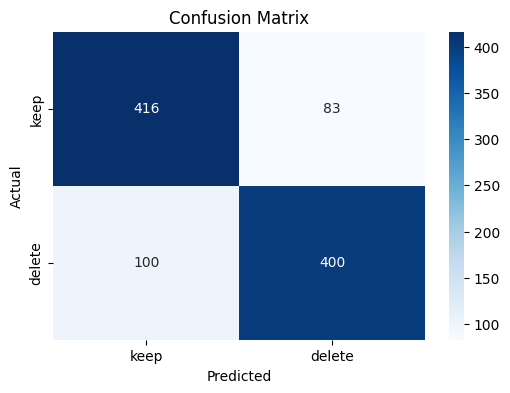

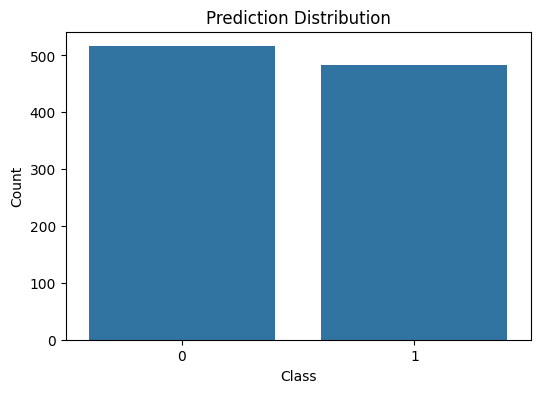

In [47]:
# Predict
y_pred = clf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["keep", "delete"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
df_cm = pd.DataFrame(cm, index=["keep", "delete"], columns=["keep", "delete"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Distribution of Predictions
pred_dist = pd.Series(y_pred).value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=pred_dist.index, y=pred_dist.values)
plt.title("Prediction Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()